# Local ToE

- In this version I have added in the other tests (KS, Anerson Darling)

In [2]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs


# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats
import time_of_emrgence_calc as toe
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/111353625.gadi-pbs/matplotlib-gqay05kt because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
client.cluster.scale(35)
client

- State start
-   Scheduler at:     tcp://127.0.0.1:45329
-   dashboard at:        /proxy/36821/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:39923'
-         Start Nanny at: 'tcp://127.0.0.1:43759'
-         Start Nanny at: 'tcp://127.0.0.1:36467'
-         Start Nanny at: 'tcp://127.0.0.1:40527'
-         Start Nanny at: 'tcp://127.0.0.1:41917'
-         Start Nanny at: 'tcp://127.0.0.1:39287'
-         Start Nanny at: 'tcp://127.0.0.1:43643'
-         Start Nanny at: 'tcp://127.0.0.1:32967'
-         Start Nanny at: 'tcp://127.0.0.1:42811'
-         Start Nanny at: 'tcp://127.0.0.1:34663'
-         Start Nanny at: 'tcp://127.0.0.1:42117'
-         Start Nanny at: 'tcp://127.0.0.1:44711'
-         Start Nanny at: 'tcp://127.0.0.1:40875'
-         Start Nanny at: 'tcp://127.0.0.1:41911'
-         Start Nanny at: 'tcp://127.0.0.1:45251'
-         Start Nanny at: 'tcp://127.0.0.1:38957'
-         Start Nanny at: 'tcp://127.0.0.1:39939'
-         S

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36821/status,
Dashboard: /proxy/36821/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45329,Workers: 28
Dashboard: /proxy/36821/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:38115,Total threads: 1
Dashboard: /proxy/36501/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:39923,


-         Start Nanny at: 'tcp://127.0.0.1:41225'


In [4]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [5]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [6]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

- Register worker <WorkerState 'tcp://127.0.0.1:46305', name: 33, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46305
- Starting established connection to tcp://127.0.0.1:44122
- Register worker <WorkerState 'tcp://127.0.0.1:39161', name: 30, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:39161
- Starting established connection to tcp://127.0.0.1:44132
- Register worker <WorkerState 'tcp://127.0.0.1:36389', name: 32, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:36389
- Starting established connection to tcp://127.0.0.1:44134
- Register worker <WorkerState 'tcp://127.0.0.1:44539', name: 28, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:44539
- Starting established connection to tcp://127.0.0.1:44158
- Register worker <WorkerState 'tcp://127.0.0.1:33299', name: 34, status: init, memory: 0, processing: 0>
- Starting

In [7]:
# Only 43MB - load into memory
best_ds = best_ds.compute()

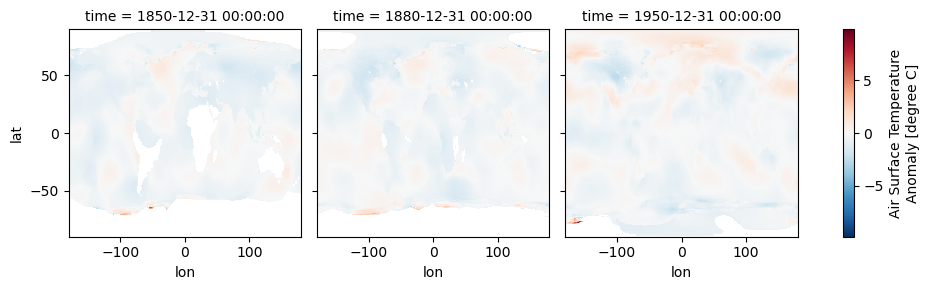

In [8]:
best_ds.isel(time=[0, 30, 100]).plot(col='time')

In [9]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
nan nan nan nan nan nan ... -0.027 -0.02725 -0.02678 -0.02644 -0.02708 -0.02708
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [10]:
base_period_ds_count = base_period_ds.count(dim='time')

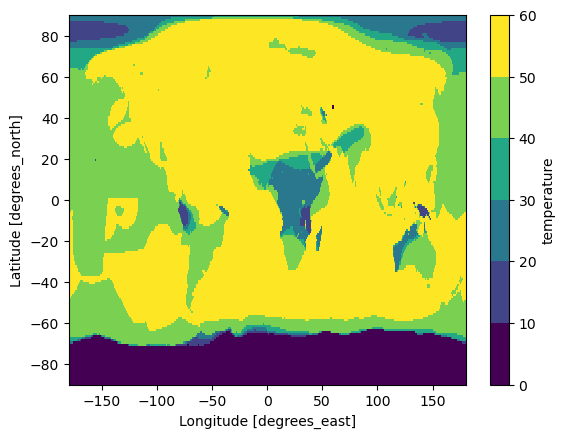

In [11]:
data_availability_levels = np.arange(0, 61, 10)

base_period_ds_count.plot(levels=data_availability_levels)

In [12]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

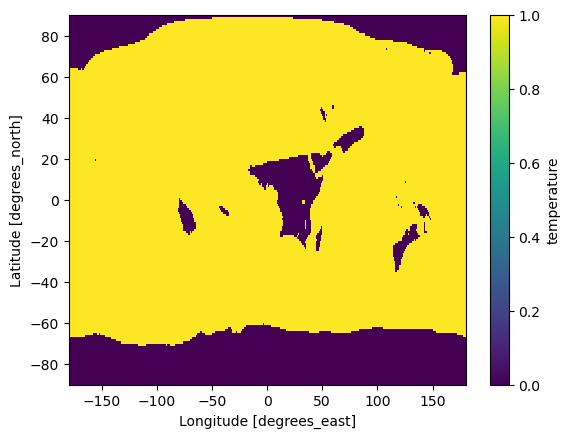

In [13]:
(data_availability_mask).plot()

In [14]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)

base_period_ds = base_period_ds.where(data_availability_mask)

In [16]:
temp_late_20th_ds = best_ds.sel(time=best_ds.time.dt.year>1981).mean(dim='time')

In [20]:
base_period_mean_ds = base_period_ds.mean(dim='time')

In [30]:
temp_late_20th_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

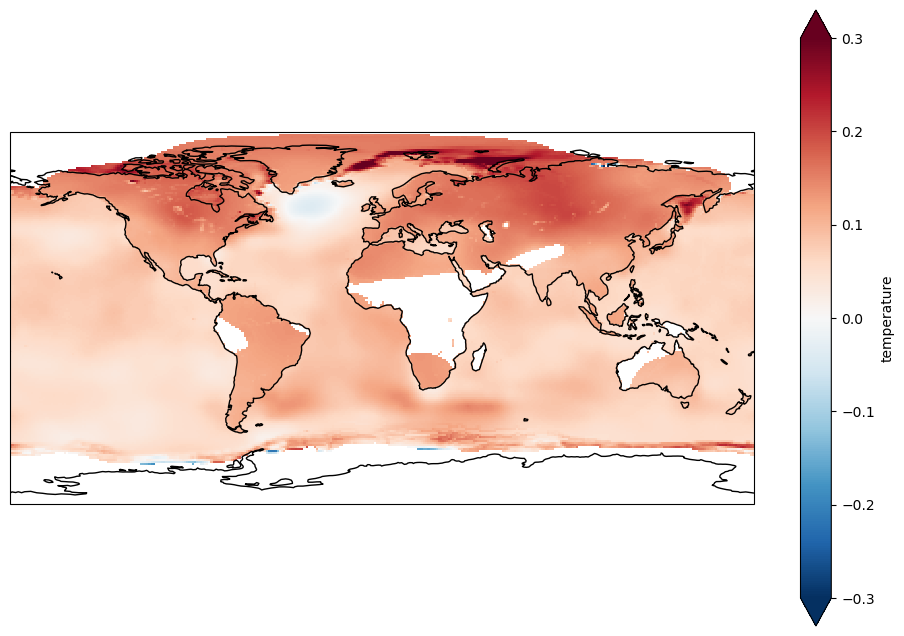

In [40]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
(((temp_late_20th_ds-base_period_mean_ds)/10)).plot(ax=ax, robust=True, cmap='RdBu_r', vmin=-.3, vmax=.3)
ax.coastlines()

# Calculations

In [20]:
window = 20

## Signal-to-Noise

### Trend Fit

In [17]:
best_ds_no_base = best_ds.sel(time=best_ds.time.dt.year>1900)
best_ds_no_base

<xarray.DataArray 'temperature' (time: 124, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [18]:
%%time
# As these are anomalies, the signal is just going to be the
ds_best_poly = stats.trend_fit(best_ds_no_base, method='POLYNOMIAL', order=4)#'LOWESS', lowess_window=40)

CPU times: user 13 s, sys: 3.22 s, total: 16.2 s
Wall time: 12.6 s


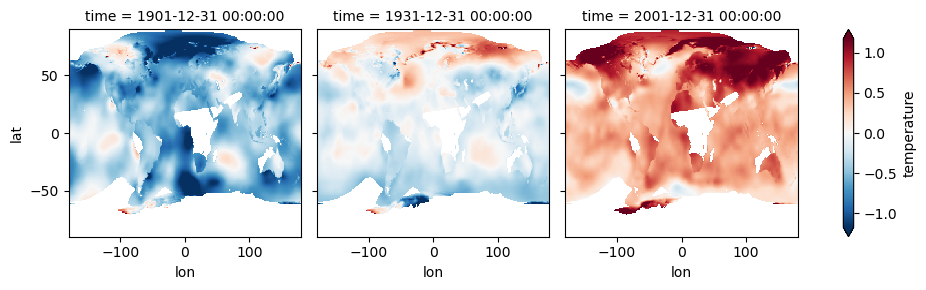

In [19]:
ds_best_poly.isel(time=[0, 30, 100]).plot(col='time', robust=True)

In [20]:
noise_ds = base_period_ds.std(dim='time')

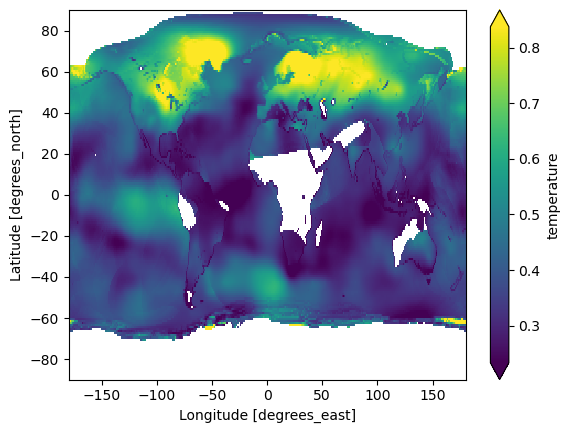

In [21]:
noise_ds.plot(robust=True)

In [22]:
base_period_ds_average = base_period_ds.mean(dim='time').fillna(0)
base_period_ds_average

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [23]:
ds_best_poly_signal = ds_best_poly - base_period_ds_average

In [24]:
ds_best_sn_poly = ds_best_poly_signal/noise_ds

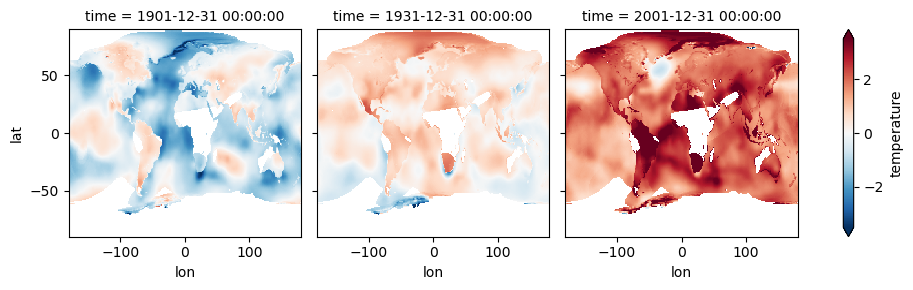

In [25]:
ds_best_sn_poly.isel(time=[0, 30, 100]).plot(col='time', robust=True)

## p-value tests

In [17]:
best_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [18]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':25, 'lon':25, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS

{'lat': 25, 'lon': 25, 'time': -1}

In [21]:
best_ds_window = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window).construct('window_dim')#[(window-1):]
best_ds_window

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360, window_dim: 20)>
dask.array<chunksize=(175, 25, 25, 20), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim
Attributes: (5)

In [22]:
base_period_window_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rename({'time':'window_dim'})

In [23]:
base_period_window_ds

<xarray.DataArray 'temperature' (window_dim: 50, lat: 180, lon: 360)>
dask.array<chunksize=(50, 25, 25), meta=np.ndarray>
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [24]:
best_ds_window = best_ds_window.persist()
base_period_window_ds = base_period_window_ds.persist()

In [25]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
        input_core_dims=[['window_dim'], ['window_dim']],
        exclude_dims={'window_dim'},
        vectorize=True,
        dask='parallelized'
    )

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 15.8 ms


In [26]:
%%time
ttest_ds = ttest_ds.compute()

CPU times: user 1min 27s, sys: 13.8 s, total: 1min 41s
Wall time: 5min 19s


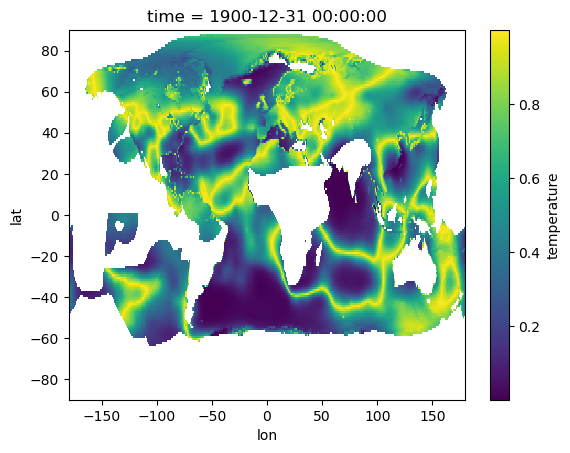

In [257]:
ttest_ds.isel(time=50).plot()

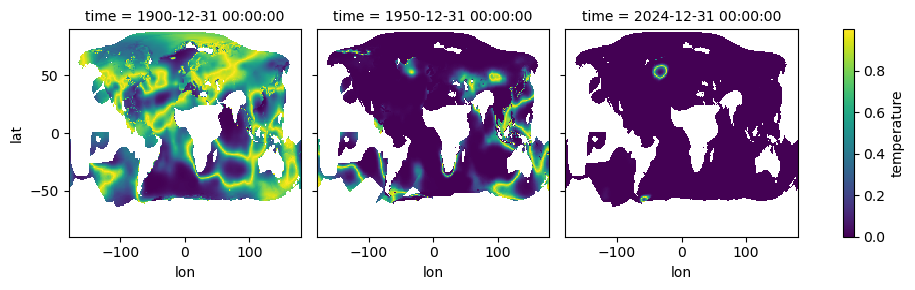

In [258]:
ttest_ds.isel(time=[50, 100, -1]).plot(col='time')

In [34]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
        input_core_dims=[['window_dim'], ['window_dim']],
        exclude_dims={'window_dim'},
        vectorize=True,
        dask='parallelized'
    ).compute()

CPU times: user 13.6 s, sys: 2.02 s, total: 15.6 s
Wall time: 48 s


In [35]:
reload(toe)

<module 'time_of_emrgence_calc' from '/home/563/ab2313/Documents/PhD/modules/time_of_emrgence_calc.py'>

In [36]:
anderson_ds = ks_ds

# xr.apply_ufunc(
#         toe.return_anderson_pvalue,
#         best_ds_window,
#         base_period_window_ds,
#         input_core_dims=[['window_dim'], ['window_dim']],
#         exclude_dims={'window_dim'},
#         vectorize=True,
#         dask='parallelized',
#         output_dtypes=float, 
#     ).compute()

In [37]:
# %%time
# ks_ds = toe.stats_test_with_ufunc(best_ds, window, base_period_ds, statistic_func=toe.return_ks_pvalue)

# %%time
# anderson_ds = toe.stats_test_with_ufunc(best_ds, window, base_period_ds, statistic_func=toe.return_anderson_pvalue)

# Getting ToE

In [226]:
PVALUE_THESHOLD1 = 0.01

In [227]:
sn_does_not_emerge = (ds_best_sn_poly.isel(time=-1) <= 2)

In [228]:
ks_does_not_emerge = (ks_ds.isel(time=-1) >= PVALUE_THESHOLD1)

In [229]:
ttest_does_not_emerge = (ttest_ds.isel(time=-1) >= PVALUE_THESHOLD1)

In [230]:
anderson_does_not_emerge = (anderson_ds.isel(time=-1) >= PVALUE_THESHOLD1)

In [231]:
# Define the colors you want
colors = [(1, 1, 1), (0.5, 0.5, 0.5)]  # White to Gray
cmap_name = 'grey_white_cmap'
# Create a LinearSegmentedColormap
grey_white_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

In [232]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [233]:
not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)

Text(0.5, 1.0, 'Anderson')

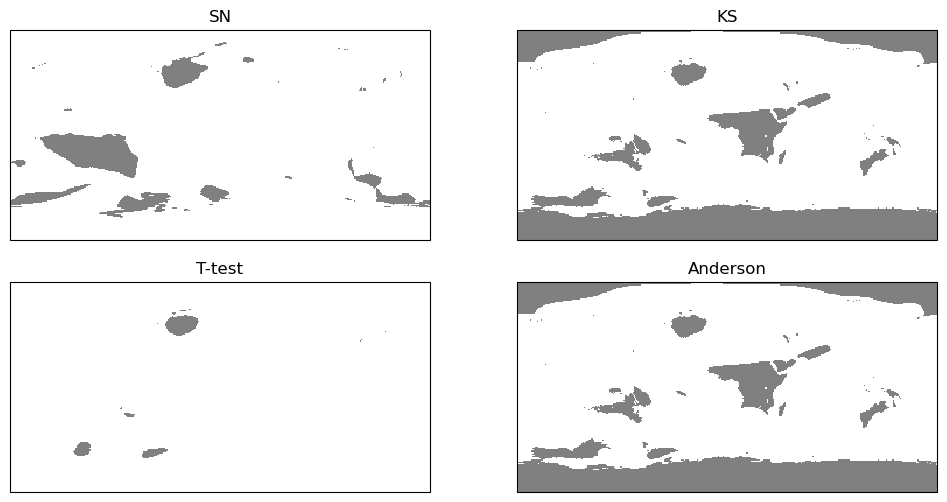

In [234]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
anderson_does_not_emerge.plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

In [235]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [236]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [237]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

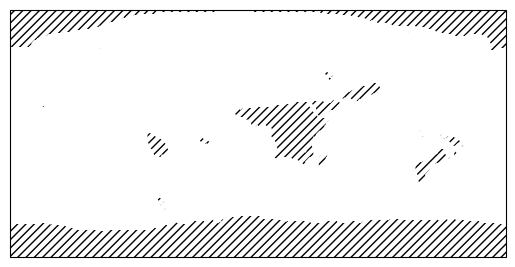

In [238]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, xr.where(data_availability_mask, False, True), **not_stable_kwargs)

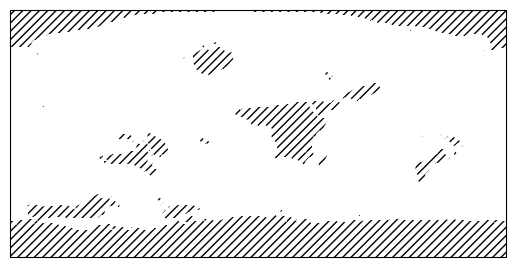

In [239]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, ks_does_not_emerge, **not_stable_kwargs)

In [240]:
sn_toe_ds = toe.get_permanent_exceedance(ds_best_sn_poly, threshold=2, comparison_func=np.greater)

In [241]:
# local_ks_subset_ds = local_ks_ds.sel(time=ks_ds.time.dt.year>1900)

In [242]:
ks_toe_ds = toe.get_permanent_exceedance(ks_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

In [243]:
ttest_toe_ds = toe.get_permanent_exceedance(ttest_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

In [244]:
anderson_toe_ds = toe.get_permanent_exceedance(anderson_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

- Event loop was unresponsive in Nanny for 8.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.20s.  This is often caused by long-runni

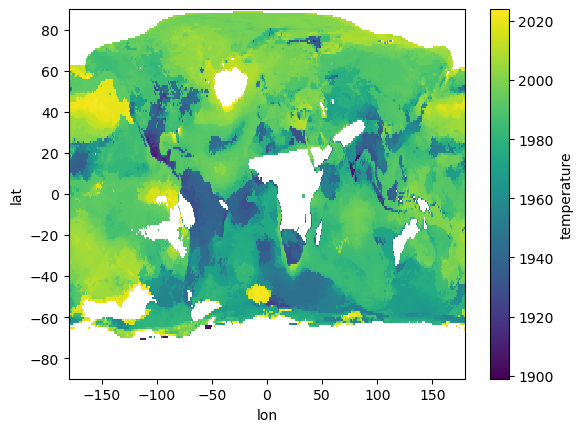

- Event loop was unresponsive in Nanny for 7.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [245]:
ks_toe_ds.plot()

## Comparison

In [246]:
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

- Event loop was unresponsive in Nanny for 7.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [1]:
data_availability_mask

NameError: name 'data_availability_mask' is not defined

- Event loop was unresponsive in Nanny for 7.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.25s.  This is often caused by long-runni

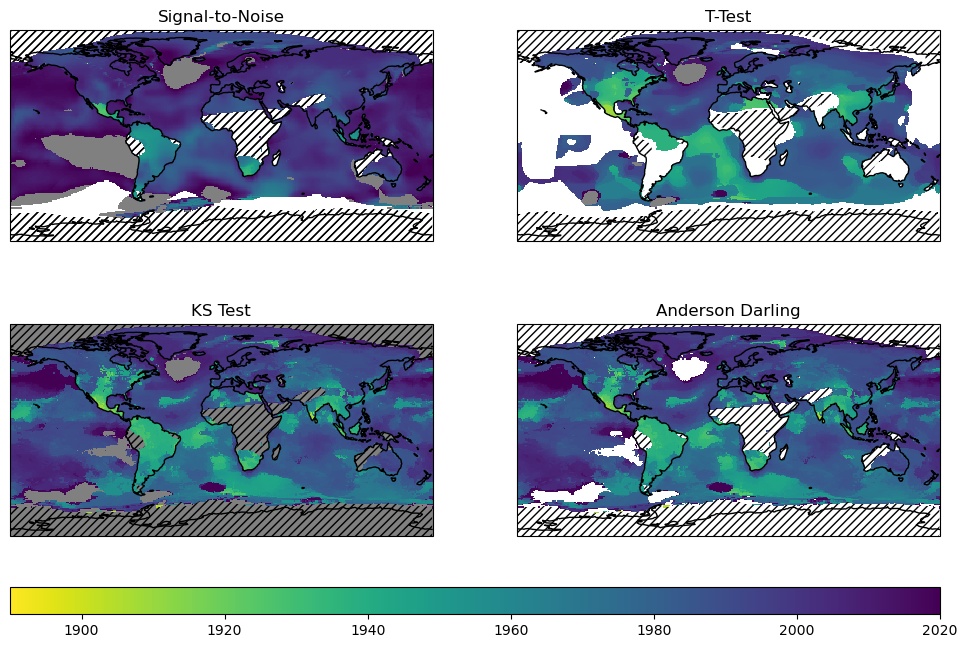

In [248]:
fig = plt.figure(figsize=(12, 8))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

# Signal-to-noise
sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
axes[0].set_title('Signal-to-Noise')
hatch(axes[0], data_unavailability_mask, **not_stable_kwargs)

# T-test
ttest_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)
axes[1].set_title('T-Test')
hatch(axes[1], xr.where(data_availability_mask, 0, 1), **not_stable_kwargs)


# KS Test
ks_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
toe_plot = ks_toe_ds.plot(ax=axes[2], **toe_plot_kwargs)
axes[2].set_title('KS Test')
# hatch(axes[2], ks_does_not_emerge, **not_stable_kwargs)


# Anderson Darling
anderson_toe_ds.plot(ax=axes[3], **toe_plot_kwargs)
axes[3].set_title('Anderson Darling')

cbar_axes1 = plt.subplot(gs[2, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


Text(0.5, 1.0, 'Difference (SN - KS)')

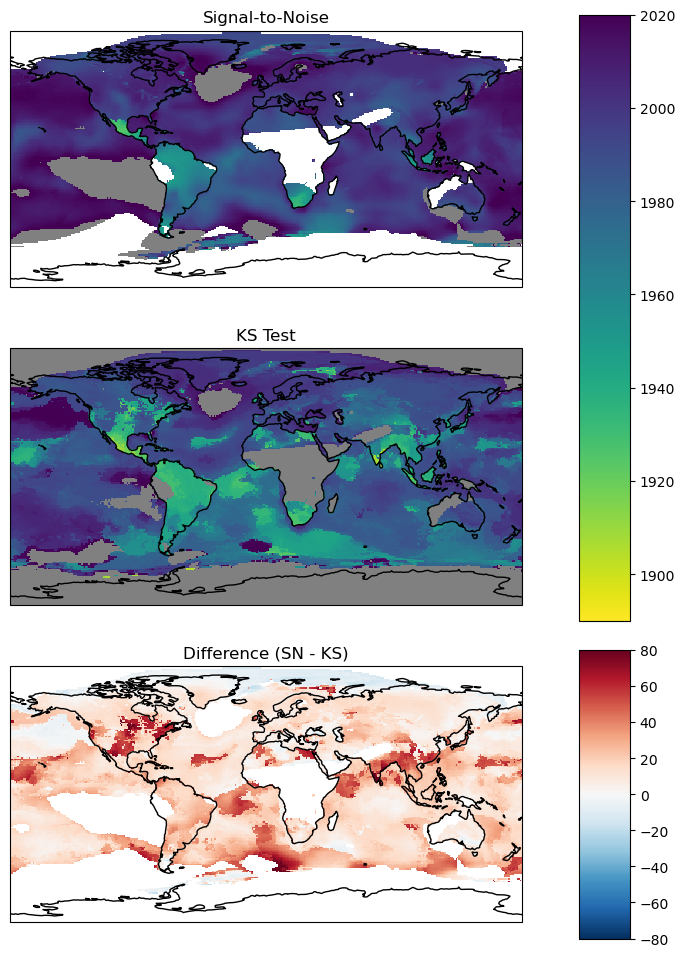

In [68]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs)


sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [ ]:
fig = plt.figure(figsize=(16, 4))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[0, i], projection=projection) for i in range(3)]

sn_toe_ds.plot(ax=axes[0], add_colorbar=False, vmin=1850, vmax=2010)
toe_plot = ks_toe_ds.plot(ax=axes[1], add_colorbar=False, vmin=1850, vmax=2010)

cbar_axes1 = plt.subplot(gs[1, :2])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[1, 2])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='horizontal')


axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [ ]:
lat=3.263204
lon=12.78272

In [ ]:
selection_kwargs = dict(lat=lat, lon=lon, method='nearest')

In [ ]:
ks_toe_ds

In [ ]:
ks_toe_ds.sel(**selection_kwargs).values

In [ ]:
sn_toe_ds.sel(**selection_kwargs).values

In [ ]:
best_ds.sel(**selection_kwargs).plot()